# ECSE 415: Assignment 3
## Segmentation & Stereo Vision
### Author: Antonios Valkanas

In [1]:
import cv2, math
import numpy as np
import matplotlib.pyplot as plt

### Question 1.1 (a)
Implement K-means clustering algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for clustering. Apply k-means to the provided image with K=2 and K=3. Display the resulting segmented images for 10 iterations in both cases.

In [2]:
# My k-means function (follows standard algorithm)
def k_means(img, k, max_iter = 10):
    h, w, channels = img.shape
    means = np.random.random_sample((k, channels)) * 255.0
    for i in range(max_iter):
        distances = np.array([img - m for m in means])
        distances = np.linalg.norm(distances, axis=-1)
        clusters = np.argmin(distances, axis = 0)
        
        img_copy = np.ndarray.copy(img)
        for cl in range(k):
            for j in range(len(img)):
                for i in range(len(img[0])):
                    if clusters[j][i] == cl:
                        img_copy[j][i] = means[cl].copy()
        for cl in range(k):
            for j in range(channels):
                means[cl][j] = np.mean(img[clusters == cl][:,j])
    return img_copy

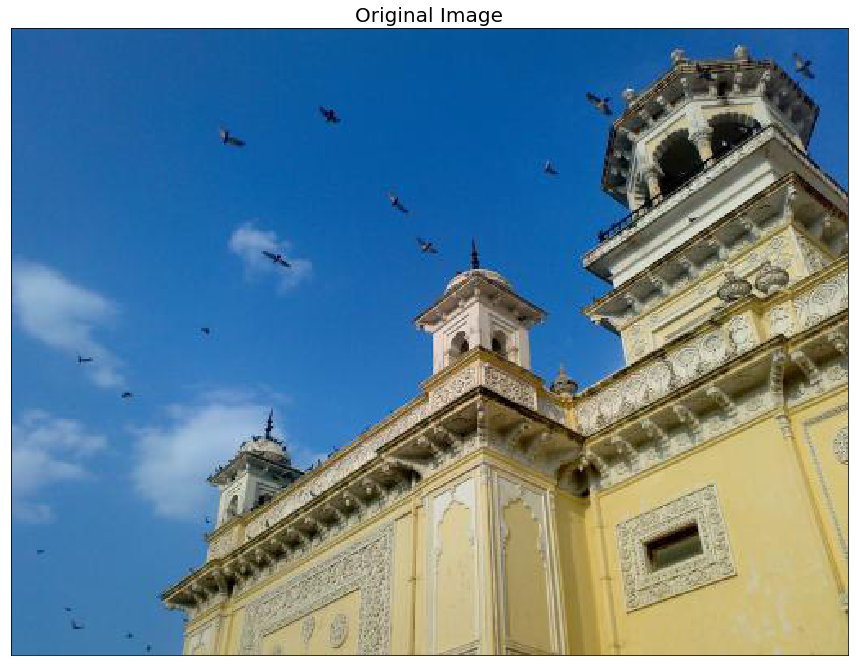

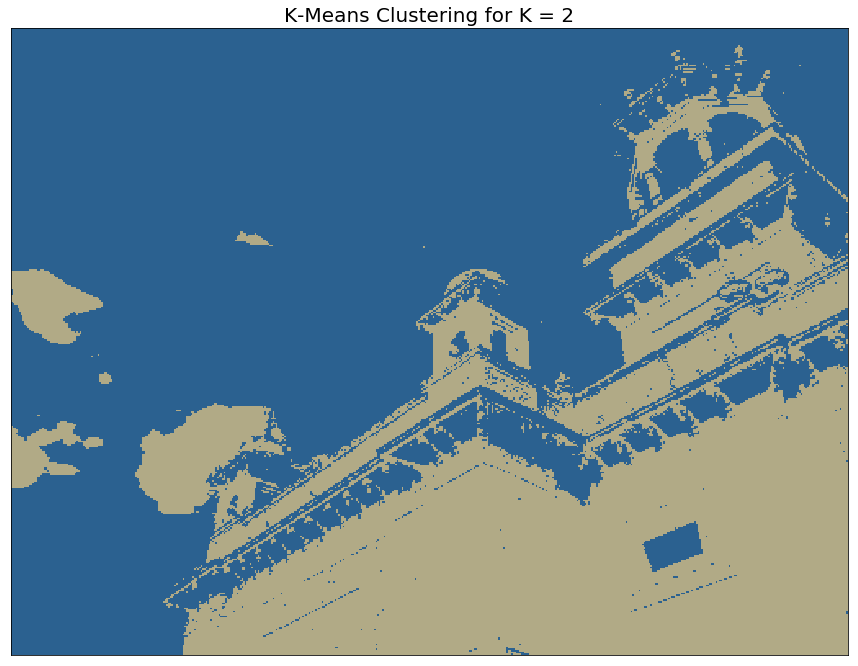

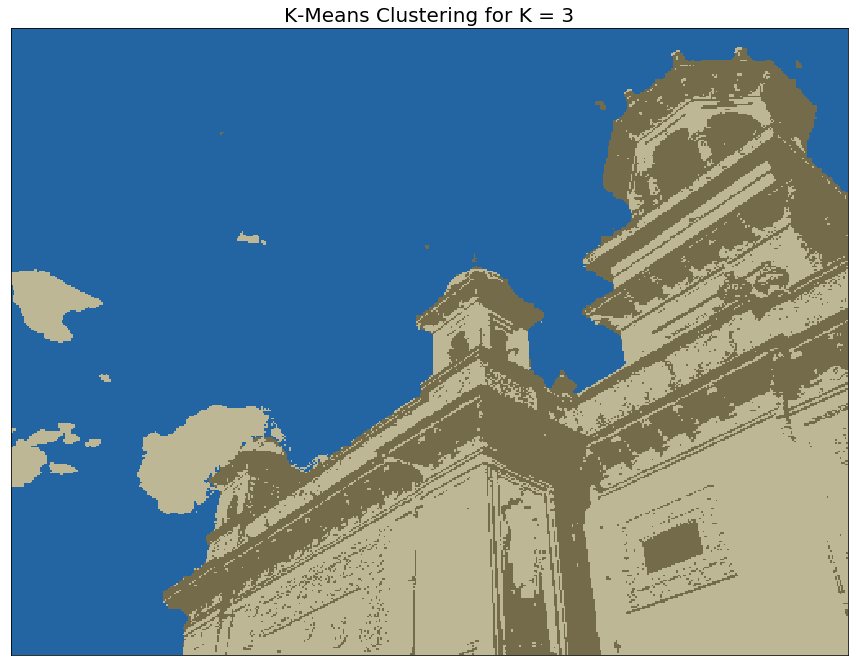

In [3]:
img = cv2.imread('home.jpg')

# Show output
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(k_means(img, 2), cv2.COLOR_BGR2RGB))
plt.title('K-Means Clustering for K = 2', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(k_means(img, 3),cv2.COLOR_BGR2RGB))
plt.title('K-Means Clustering for K = 3', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

### Question 1.1 (b)
Implement the EM algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images. Apply it to the given image with 2 and 3 Gaussian components. Display the resulting segmented images for 10 iterations in both cases.

In [4]:
def em_gmm(img, k, max_iter = 10):
    img = img*1.0/np.max(img)
    data = img
    data = np.reshape(data,(data.shape[0] * data.shape[1], -1))
    # Initialize model parameters
    cov = np.zeros((k,3,3))
    cov[:] = np.eye(3)    
    alpha = 1/k*np.ones(k)
    mean = np.array([img[np.random.randint(0, len(img))]
                    [np.random.randint(0, len(img[0]))] for i in range(k)])
    
    #Variables for forloop control and state saving.
    for _ in range(max_iter):
        cluster_prob = np.zeros(k)
        temp_mean = np.zeros_like(mean)
        temp_cov = np.zeros_like(cov)
        
        #E step
        clusters = np.zeros((data.shape[0],mean.shape[0]))
        # Find each probabilities.
        for i in range(data.shape[0]):
            for j in range(mean.shape[0]):
                temp = (data[i] - mean[j])
                cluster = alpha[j] * (1/np.sqrt(2*np.pi)/np.sqrt(np.linalg.det(cov[j])))
                cluster *= np.exp(-0.5*np.dot(np.dot(temp,np.linalg.inv(cov[j])),np.transpose(temp)))
                clusters[i][j] = cluster
        # Make probabilities sum to 1.
            clusters[i] /= sum(clusters[i])
        
        #M step
        for i in range(k):
            for j in range(data.shape[0]):
                cluster_prob[i] += clusters[j][i]

        # Update mean, covariance.
        for i in range(k):
            for j in range(data.shape[0]):
                # Update mean
                temp_mean[i] += data[j] * clusters[j][i]
                # Update covariance
                temp = (data[j] - mean[i])[np.newaxis]
                temp_cov[i] += clusters[j][i] * np.dot(np.transpose(temp), (temp))
            temp_mean[i] /= cluster_prob[i]
            temp_cov[i] /= cluster_prob[i]  

        mean = temp_mean
        cov = temp_cov
        # Update alpha
        alpha = cluster_prob / data.shape[0]
    
    # Return result
    output = data.copy() #Get general shape of data
    for j in range(data.shape[0]):
        clf = 0
        max_likelihood = 0
        for i in range(k):
            if(clusters[j][i] > max_likelihood):
                max_likelihood = clusters[j][i]
                clf = i
        output[j] = mean[clf]
    return np.reshape(output,(img.shape))

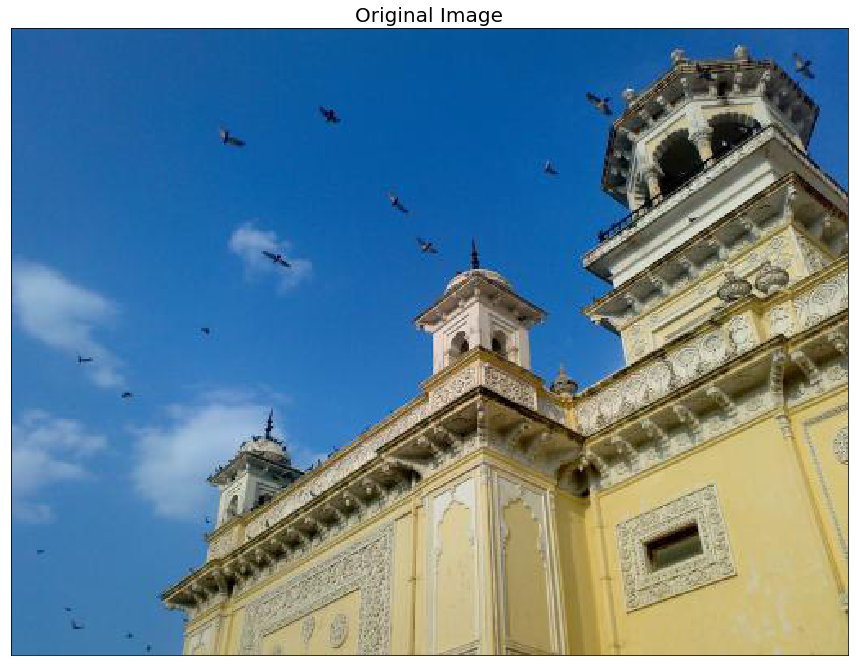

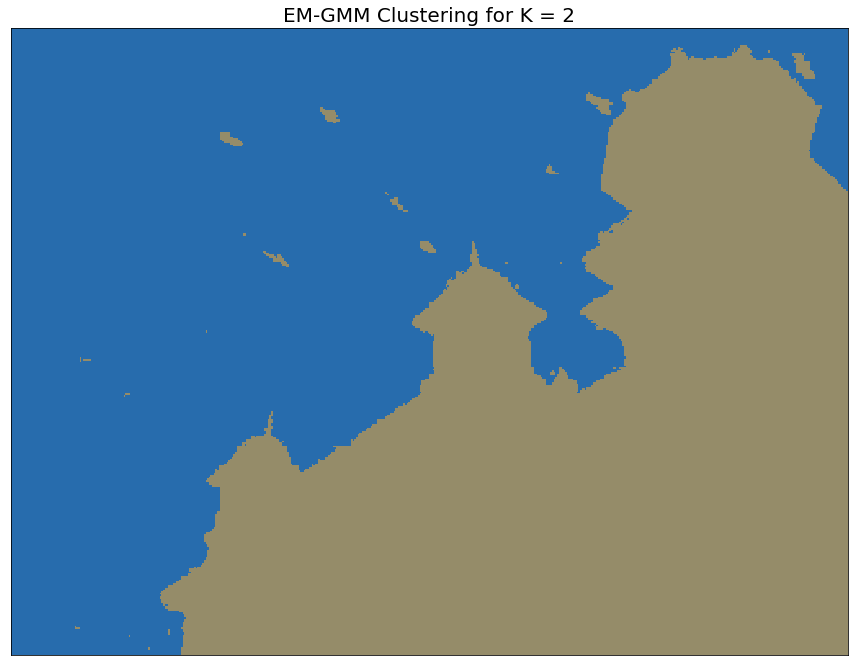

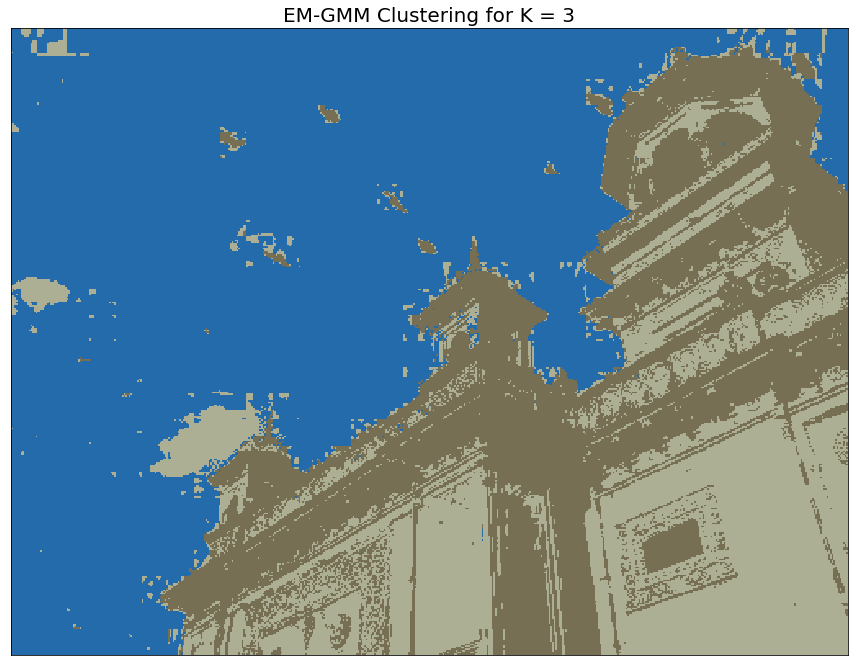

In [5]:
img = cv2.imread('home.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Use line below to quickly run the algorithm on a smaller image.
#img = cv2.resize(img, (44, 25))
# Show output
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.title('Original Image', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(em_gmm(img,2))
plt.title('EM-GMM Clustering for K = 2', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(em_gmm(img,3))
plt.title('EM-GMM Clustering for K = 3', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

### Question 1.1 (c)
Under what data distribution conditions would K-means and EM give the
same solution, provided similar initializations?

* EM for Gaussian mixture models is a probabilistic method where each point is assigned a probability of belonging to a cluster and is assigned to the cluster that it is more likely to belong to.
* K-means works by assigning each data point (or pixel in our case) to a cluster. The assignment to each cluster depends on the euclidean distance between the center of the cluster.
* As we can see EM-GMM can work for any geometric configuration of datapoints per cluster. On the other hand, using the euclidean distance as criterion for assignment biases the K-means method towards choosing circular/spherical clusters as this way the center of the cluster would be equidistant from the datapoints it assigned to it. From this we conclude that the methods will produce similar results (assuming similar initializations) as long as the image has circular segments of pixels.